## 1. 可视化CIFAR-100数据集中的图片（每类中随机选择10张）

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import beta
import pickle
import torch
import os

In [2]:
def load_labels_name(filename):
    '''
    使用pickle反序列化labels文件，得到存储内容
    反序列化之后得到字典对象，可根据key取出相应内容
    '''
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj
        
def load_data_cifar(filename, mode='cifar100'):
    '''
    load data and labels information from cifar100
    cifar100 keys(): dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
    '''
    with open(filename,'rb') as f:
        dataset = pickle.load(f, encoding='bytes')
        if mode == 'cifar100':
            data = dataset[b'data']
            labels = dataset[b'fine_labels']
            img_names = dataset[b'filenames']
        else:
            print("mode should be 'cifar100'")
            return None, None, None
        
    return data, labels, img_names

def load_cifar100(cifar100_path, mode = 'train'):
    if mode == "train":
        filename = os.path.join(cifar100_path, 'train')
        print("Loading {}".format(filename))
        data, labels, img_names = load_data_cifar(filename, mode='cifar100')
    elif mode == "test":
        filename = os.path.join(cifar100_path, 'test')
        print("Loading {}".format(filename))
        data, labels, img_names = load_data_cifar(filename, mode='cifar100')
    else:
        print("mode should be in ['train', 'test']")
        return None, None, None
    
    return data, labels, img_names
    
def to_pil(data):
    r = Image.fromarray(data[0])
    g = Image.fromarray(data[1])
    b = Image.fromarray(data[2])
    pil_img = Image.merge('RGB', (r,g,b))
    return pil_img
 
def random_visualize(imgs, labels, label_names):
    figure = plt.figure(figsize=(len(label_names),10))
    idxs = list(range(len(imgs)))
    np.random.shuffle(idxs)
    count = [0]*len(label_names)
    for idx in idxs:
        label = labels[idx]
        if count[label]>=10:
            continue
        if sum(count)>10 * len(label_names):
            break
        
        img = to_pil(imgs[idx])
        label_name = label_names[label]
        
        subplot_idx = count[label] * len(label_names) + label + 1
        #print(label, subplot_idx)
        plt.subplot(10,len(label_names), subplot_idx)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if count[label] == 0:
            plt.title(label_name)
 
        count[label] += 1   
    
    plt.savefig('random_visualization_cifar100.png')
    plt.show()

Loading .\data\cifar-100-python\train
Loading .\data\cifar-100-python\test


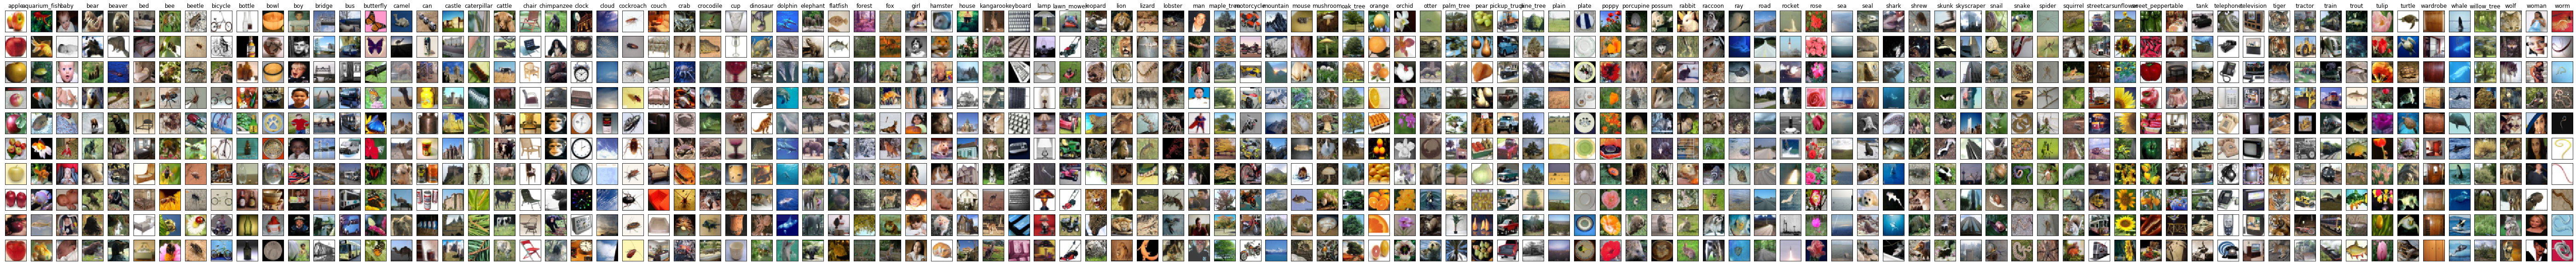

In [3]:
cifar100_path = r".\data\cifar-100-python"
obj_cifar100 = load_labels_name(os.path.join(cifar100_path, 'meta')) # coarse_label_names、fine_label_names
    
# 提取cifar100的图片数据、标签、文件名
data_cifar100_train,labels_cifar100_train,img_names_cifar100_train = load_cifar100(cifar100_path, mode = 'train')
data_cifar100_test,labels_cifar100_test,img_names_cifar100_test = load_cifar100(cifar100_path, mode = 'test')
imgs_cifar100_train = data_cifar100_train.reshape(data_cifar100_train.shape[0],3,32,32)
imgs_cifar100_test = data_cifar100_test.reshape(data_cifar100_test.shape[0],3,32,32)
 
# visualize fro cifar100
label_names_cifar100 = obj_cifar100['fine_label_names']
random_visualize(imgs=imgs_cifar100_train, labels=labels_cifar100_train,label_names=label_names_cifar100)

In [4]:
obj_cifar100['coarse_label_names']

['aquatic_mammals',
 'fish',
 'flowers',
 'food_containers',
 'fruit_and_vegetables',
 'household_electrical_devices',
 'household_furniture',
 'insects',
 'large_carnivores',
 'large_man-made_outdoor_things',
 'large_natural_outdoor_scenes',
 'large_omnivores_and_herbivores',
 'medium_mammals',
 'non-insect_invertebrates',
 'people',
 'reptiles',
 'small_mammals',
 'trees',
 'vehicles_1',
 'vehicles_2']

## 2. 对三张训练样本分别经过cutmix, cutout, mixup后进行可视化

In [5]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb')as f:
        datadict = pickle.load(f,encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'coarse_labels']+datadict[b'fine_labels']
        X = X.reshape(50000, 3, 32, 32)
        Y = np.array(Y)
        return X, Y

In [6]:
imgX, imgY = load_CIFAR_batch(cifar100_path + "\\train")
print(imgX.shape)

(50000, 3, 32, 32)


In [7]:
# 转为RGB三通道
def convert_img(imgs):
    img0 = imgs[0]
    img1 = imgs[1]
    img2 = imgs[2]
    i0 = Image.fromarray(img0).convert('L')
    i1 = Image.fromarray(img1).convert('L')
    i2 = Image.fromarray(img2).convert('L')
    img = Image.merge("RGB", (i0, i1, i2))
    return img

In [8]:
def rand_box(img,length): # 随机生成cut区域
    h = img.shape[1]
    w = img.shape[2]
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - length // 2, 0, h)
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)    
    return x1, y1, x2, y2

def mixup(img0, img1, lam):
    mixed_img = lam * img0 + (1 - lam) * img1
    return mixed_img

def cutout(img,randbox):
    mask = np.ones((img.shape[1], img.shape[2]), np.float32)
    x1, y1, x2, y2 = randbox[0],randbox[1],randbox[2],randbox[3]
    mask[x1: x2, y1: y2] = 0.
    img = img * mask
    return img

def cutmix(img0, img1, randbox, lam):
    img = img0.copy()
    bbx1, bby1, bbx2, bby2 = randbox[0],randbox[1],randbox[2],randbox[3]
    img[:,bbx1:bbx2, bby1:bby2] = img1[:, bbx1:bbx2, bby1:bby2]
    return img

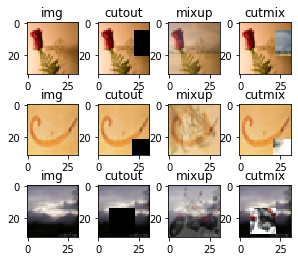

In [9]:
N = 3
length = 16
lam = 0.7

for idx in range(N):
    
    i,j = np.random.randint(0,len(imgX),2)
    train_img = imgX[i]
    rand_img = imgX[j]
    randbox = rand_box(train_img,length)

    img_cutout = cutout(train_img, randbox)
    img_mixup = mixup(train_img, rand_img, lam)
    img_cutmix = cutmix(train_img, rand_img,randbox, lam)
    

    plt.subplot(N,5,idx*5+1)
    img2 = convert_img(train_img)
    plt.imshow(img2)
    plt.title('img')

    plt.subplot(N,5,idx*5+2)
    img_cutout2 = convert_img(img_cutout)
    plt.imshow(img_cutout2)
    plt.title('cutout')

    plt.subplot(N,5,idx*5+3)
    img_mixup2 = convert_img(img_mixup)
    plt.imshow(img_mixup2)
    plt.title('mixup')

    plt.subplot(N,5,idx*5+4)
    img_cutmix2 = convert_img(img_cutmix)
    plt.imshow(img_cutmix2)
    plt.title('cutmix')

    #plt.subplot(N,5,idx*5+5)
    #rand_img2 = convert_img(rand_img)
    #plt.imshow(rand_img2)
    #plt.title('img_mix')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=0.375, hspace=0.5)
plt.savefig("_aug_vis.png")
plt.show()